In [1]:
from DQbee import *
from DQbee.EquationSystem import *
import sympy as sp
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np

### Small bistable model

---

Consider the following scalar ODE:
$$
x' = k_1 x^2 - k_2 x^3 - k_3 x,
$$
where $k_1, k_2, k_3$ are positive reaction rate constants.
The equation has always one dissipative equilibrium at $x = 0$.
It has two more equilibria as long as $k_1^2 > 4k_2k_3$, and in this case the largest of them will be dissipative as well.
For any nonzero parameter values, the inner-quadratic quadratization computed by Algorithm 1 will consist of a single new variable $w := x^2$ and the quadratic system:
\begin{equation}
  x' = k_1w - k_2xw - k_3x, \quad w' = 2k_1xw - 2k_2w^2 - 2k_3w.
\end{equation}
For the case-study, we pick $k_1 = 0.4, k_2 = 1, k_3 = 0.03$.
For these parameter values, the dissipative equilibria are $x = 0$ and $x = 0.3$, and Algorithm 3 finds the system (1) is dissipative at them already

In [2]:
x, k1, k2, k3 = symbols('x k1 k2 k3')
t = sp.symbols('t')
k1, k2, k3 = 0.4, 1, 0.03

bistable_model = EquationSystem([sp.Eq(x, k1 * x ** 2 - k2 * x ** 3 - k3 * x)])

Now we try to test whether the system (1) is dissipative at the equilibrium or not.

In [3]:
w = symbols('w')

quadratic_bistable_model = [
    sp.Eq(x, k1 * w - k2 * x * w - k3 * x),
    sp.Eq(w, 2 * k1 * x * w - 2 * k2 * w ** 2 - 2 * k3 * w)
]

bistable_matrix = [eq.rhs for eq in quadratic_bistable_model]
jacobian_bistable = sp.Matrix(bistable_matrix).jacobian([x, w])
jacobian_bistable

Matrix([
[-w - 0.03,             0.4 - x],
[    0.8*w, -4*w + 0.8*x - 0.06]])

In [4]:
equilibrium = [{x:0, w:0}, {x:0.3, w:0.09}]
is_dissipative = True
for eq in equilibrium:
    jacobian_bi = jacobian_bistable.subs(eq)
    max_real_eigen = max([complex(eigen).real for eigen in jacobian_bi.eigenvals().keys()])
    if max_real_eigen >= 0:
        print("Stable equilibrium point: ", eq)
        is_dissipative = False
if is_dissipative:
    print("The system is dissipative")

The system is dissipative


### Simulation of the plot

---

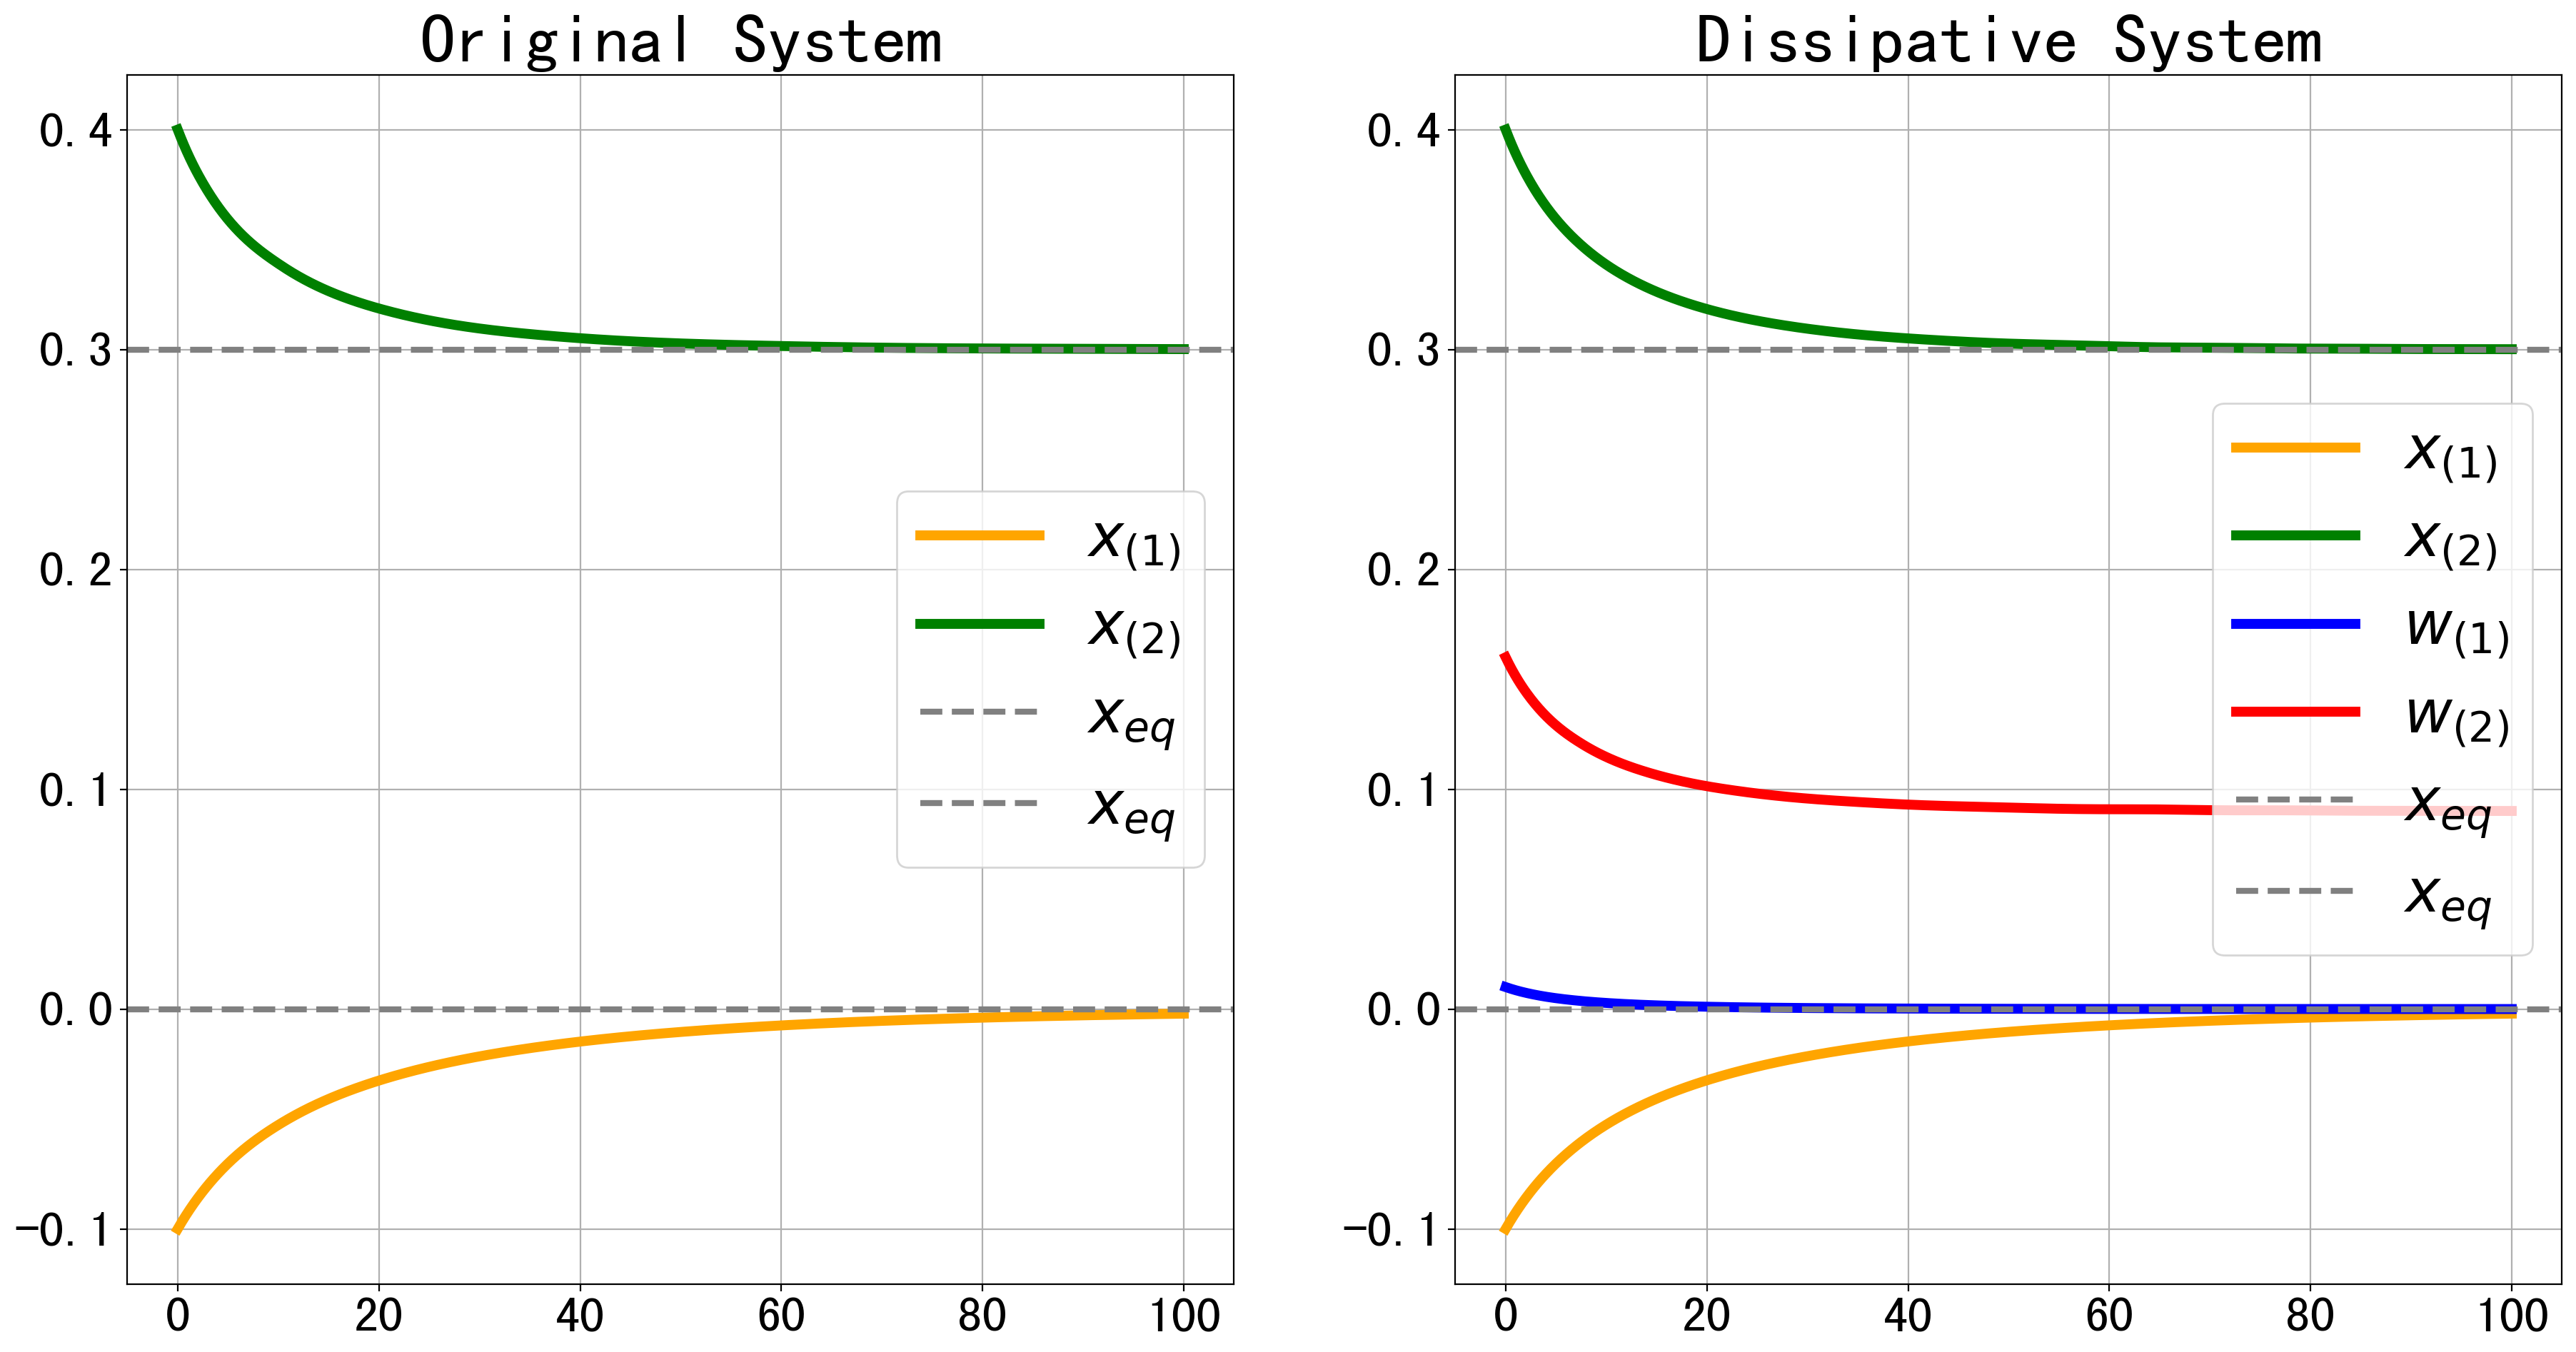

In [5]:
bistable_original = [k1 * x ** 2 - k2 * x ** 3 - k3 * x]
bistable_quadra = [k1 * w - k2 * x * w - k3 * x, 2 * k1 * x * w - 2 * k2 * w ** 2 - 2 * k3 * w]

initial_state_original_1 = [-0.1]
initial_state_original_2 = [0.4]
initial_state_quadra_1 = [-0.1, 0.01]
initial_state_quadra_2 = [0.4, 0.16]

fun_bistable_original = sp.lambdify((t, [x]), bistable_original, 'numpy')
fun_bistable_quadra = sp.lambdify((t, [x, w]), bistable_quadra, 'numpy')

t_span = [0, 100]
t_eval = np.linspace(t_span[0], t_span[1], 1000)

sol_original_1 = solve_ivp(fun_bistable_original, t_span, initial_state_original_1, method='RK45', t_eval=t_eval)
sol_original_2 = solve_ivp(fun_bistable_original, t_span, initial_state_original_2, method='RK45', t_eval=t_eval)
sol_quadra_1 = solve_ivp(fun_bistable_quadra, t_span, initial_state_quadra_1, method='RK45', t_eval=t_eval)
sol_quadra_2 = solve_ivp(fun_bistable_quadra, t_span, initial_state_quadra_2, method='RK45', t_eval=t_eval)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 11))

ax1.plot(sol_original_1.t, sol_original_1.y[0], 'orange', label=r'$x_{(1)}$', linewidth=5)
ax1.plot(sol_original_2.t, sol_original_2.y[0], 'green', label=r'$x_{(2)}$', linewidth=5)
ax1.axhline(y=0.3, color='gray', linestyle='--', linewidth=3, label=r'$x_{eq}$')
ax1.set_title(r'Original System', size=35)
# ax1.set_xlabel('t', size=20)
# ax1.set_ylabel('x(t)', size=20)
ax1.axhline(y=0, color='gray', linestyle='--', linewidth=3, label=r'$x_{eq}$')
ax1.legend(loc='best', prop={'size': 30})
ax1.grid()

ax2.plot(sol_quadra_1.t, sol_quadra_1.y[0], 'orange', label=r'$x_{(1)}$', linewidth=5)
ax2.plot(sol_quadra_2.t, sol_quadra_2.y[0], 'green', label=r'$x_{(2)}$', linewidth=5)
ax2.plot(sol_quadra_1.t, sol_quadra_1.y[1], 'b', label=r'$w_{(1)}$', linewidth=5)
ax2.plot(sol_quadra_2.t, sol_quadra_2.y[1], 'r', label=r'$w_{(2)}$', linewidth=5)
ax2.set_title(r'Dissipative System', size=35)
# ax2.set_xlabel('t', size=20)
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=3, label=r'$x_{eq}$')
ax2.axhline(y=0.3, color='gray', linestyle='--', linewidth=3, label=r'$x_{eq}$')
ax2.legend(loc='best', prop={'size': 30})
ax2.grid()

# ax3.plot(sol_quadra_2.t, sol_quadra_2.y[0], 'orange', label='x', linewidth=4)
# # ax2.plot(sol_quadra_1.t, sol_quadra_1.y[1], 'orange', label=r'w', linewidth=4)
# ax3.plot(sol_quadra_2.t, sol_quadra_2.y[1], 'blue', label='w', linewidth=4)
# ax3.set_title('Dissipative System', size=28)
# # ax3.set_xlabel('t', size=20)
# ax3.axhline(y=0.3, color='gray', linestyle='--', linewidth=3, label=r'$x_{eq}$')
# ax3.legend(loc='best', prop={'size': 26})
# ax3.grid()

ax1.tick_params(axis='both', which='major', labelsize=25)
ax2.tick_params(axis='both', which='major', labelsize=25)

plt.savefig("../../figure/bistable_simulation_1.png", dpi=1000, bbox_inches = 'tight')

plt.show()